### Import required packages

In [17]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')



# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, roc_curve, accuracy_score, auc, confusion_matrix
from prettytable import PrettyTable

%matplotlib inline

### Helper function for plotting

In [21]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # roc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'Recall', 'Percision','False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_recall, train_precision, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1,test_recall, test_precision, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far, test_recall, test_precision

In [23]:
train = pd.read_csv('cleaned_train.csv')

In [24]:
# Numeric features column names
df_numeric = train.select_dtypes(include=np.number)

### Split the data to features and target

In [27]:
df_numeric.columns

Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

In [28]:
X = df_numeric.iloc[:,1:-1]
y = df_numeric.iloc[:, -1]

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42 , stratify=y)

### Baseline model: linear regression

+---------+-------+--------------------+--------------------+--------------------+--------------------+---------------------+
| Dataset | Model |        AUC         |      F1-score      |       Recall       |     Percision      |   False Alarm Rate  |
+---------+-------+--------------------+--------------------+--------------------+--------------------+---------------------+
|  Train  |   lr  | 0.7865162860015802 | 0.8987416415402931 | 0.9669611434317317 | 0.8395136146331325 | 0.21348371399841987 |
|   Test  |   lr  | 0.785529408283158  | 0.8986736162433389 | 0.9679635784710778 | 0.8386409834478753 | 0.21447059171684205 |
+---------+-------+--------------------+--------------------+--------------------+--------------------+---------------------+


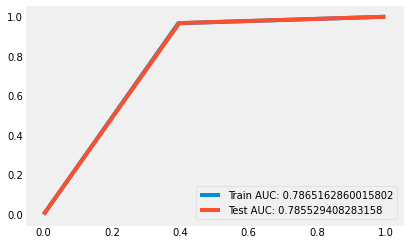

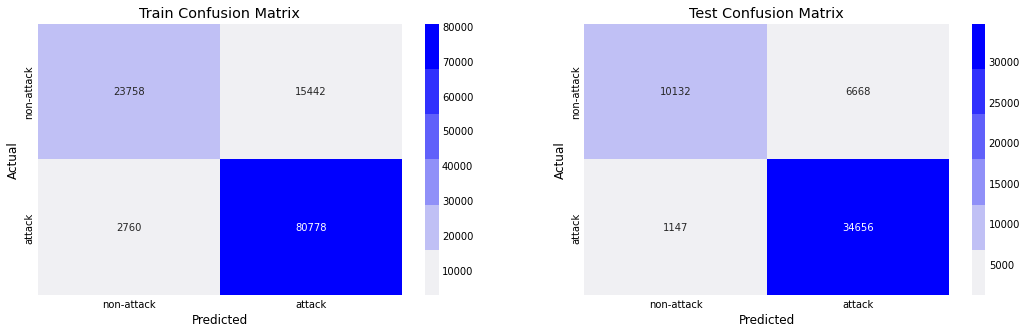

(LogisticRegression(),
 0.785529408283158,
 0.8986736162433389,
 0.21447059171684205,
 0.9679635784710778,
 0.8386409834478753)

In [30]:
lr = LogisticRegression()

evaluate_result(lr, X_train, y_train, X_val, y_val, "lr")